In [2]:
import toliman
import toliman.math as math
import toliman.constants as const
import jax
import jax.numpy as np
import jax.random as jr
import jax.lax as jl
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
import dLux 
import equinox
import os
import chainconsumer as cc

In [8]:
mpl.rcParams["text.usetex"] = True
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams["image.cmap"] = "inferno"

In [4]:
os.chdir("".join(os.getcwd().partition("toliman")[:2]))

In [5]:
model: object = dLux.Instrument(
    optics = toliman.TolimanOptics(operate_in_static_mode = True),
    detector = toliman.TolimanDetector(),
    sources = [toliman.AlphaCentauri(), toliman.Background(number_of_bg_stars = 5)]
)

In [6]:
psf: float = model.model()
data: float = math.simulate_data(psf, 0.001* np.linalg.norm(psf))
fdata: float = data.flatten()

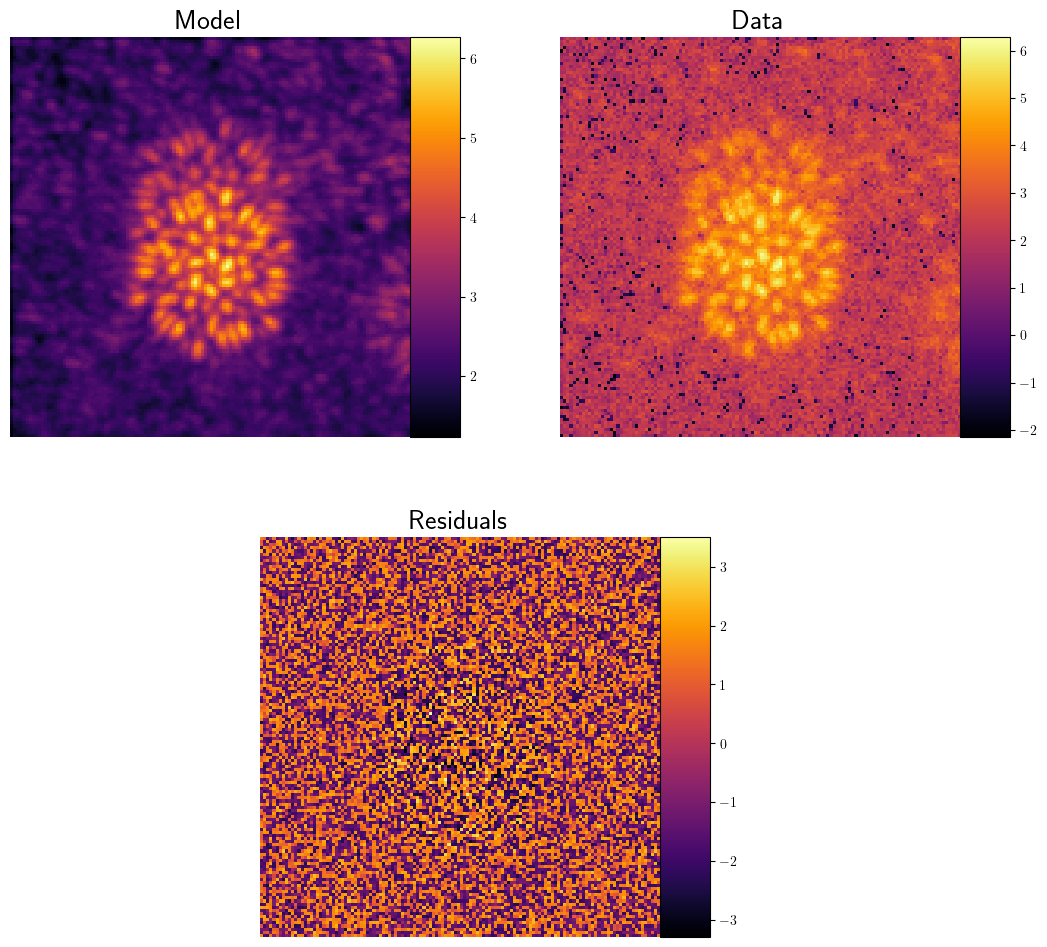

In [10]:
def plot_image_with_cbar(
        figure: object,
        image: float, 
        corner: list, 
        width: float, 
        height: float,
        title: str,
    ) -> object:
    x: float = corner[0]
    y: float = corner[1]
    im_axes: object = figure.add_axes([x, y, width, height])
    cbar_ax: object = figure.add_axes([x + width, y, 0.05, height])
    im_cmap: object = im_axes.imshow(image)
    im_cbar: object = figure.colorbar(im_cmap, cax = cbar_ax)
    im_ticks: list = im_axes.axis("off")
    im_frame: None = im_axes.set_frame_on(False)
    im_title: object = im_axes.set_title(title) 
    return figure

size: float = 5.0
figure: object = plt.figure(figsize = (2 * size, 2 * size))
subfigures: object = figure.subfigures(2, 1)

psf_fig: object = plot_image_with_cbar(
    subfigures[0], np.cbrt(psf), [0.0, 0.1], 0.4, 0.8, "Model"
)
psf_fig: object = plot_image_with_cbar(
    psf_fig, np.cbrt(data), [0.55, 0.1], 0.4, 0.8, "Data"
)
res_fig: object = plot_image_with_cbar(
    subfigures[1], np.cbrt(psf - data), [0.25, 0.1], 0.4, 0.8, "Residuals"
)
figure.savefig("psf.png")

In [9]:
true_pixel_scale: float = const.get_const_as_type("TOLIMAN_DETECTOR_PIXEL_SIZE", float)
true_separation: float = const.get_const_as_type("ALPHA_CENTAURI_SEPARATION", float)

In [11]:
def hmc_model(model: object) -> None:
    position_in_pixels: float = npy.sample(
        "position_in_pixels", 
        dist.Uniform(-5, 5), 
        sample_shape = (2,)
    ) 
    position: float = npy.deterministic(
        "position", 
        position_in_pixels * true_pixel_scale
    )

    logarithmic_separation: float = npy.sample(
        "logarithmic_separation", 
        dist.Uniform(-5, -4)
    )
    separation: float = npy.deterministic(
        "separation", 
        10 ** (logarithmic_separation)
    )
    
#     x_projection: float = npy.sample("x_projection", dist.Normal(0, 1))
#     y_projection: float = npy.sample("y_projection", dist.HalfNormal(1))
#     position_angle: float = npy.deterministic(
#         "position_angle", 
#         np.arctan2(y_projection, x_projection)
#     )

    logarithmic_flux: float = npy.sample("logarithmic_flux", dist.Uniform(4, 6))
    flux: float = npy.deterministic("flux", 10 ** logarithmic_flux)

    logarithmic_contrast: float = npy.sample("logarithmic_contrast", dist.Uniform(-4, 2))
    contrast: float = npy.deterministic("contrast", 10 ** logarithmic_contrast)

    paths: list = [
        "BinarySource.position",
        "BinarySource.separation",
#         "BinarySource.position_angle",
        "BinarySource.flux",
        "BinarySource.contrast",
    ]
    
    values: list = [
        position,
        separation,
#         position_angle,
        flux,
        contrast,
    ]
        
    with npy.plate("data", len(fdata)):
        poisson_model: float = dist.Poisson(
            model.update_and_model("model", paths, values, flatten=True)
        )
        return npy.sample("psf", poisson_model, obs=fdata)

In [12]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(hmc_model),    
    num_warmup=500,
    num_samples=500,
    num_chains=1,
    progress_bar=True,
)

In [13]:
sampler.run(jr.PRNGKey(0), model, init_params = model)

sample: 100%|██████████| 1000/1000 [1:07:57<00:00,  4.08s/it, 7 steps of size 2.28e-01. acc. prob=0.91] 


In [14]:
samples: float = sampler.get_samples().copy()

In [15]:
logarithmic_contrast_samples: float = samples.pop("logarithmic_contrast")
logarithmic_flux_samples: float = samples.pop("logarithmic_flux")
logarithmic_separation_samples: float = samples.pop("logarithmic_separation")
# x_projection_samples: float = samples.pop("x_projection")
# y_projection_samples: float = samples.pop("y_projection")
position_in_pixels_samples: float = samples.pop("position_in_pixels")

In [16]:
samples.update({"x": samples.get("position")[:, 0], "y": samples.get("position")[:, 1]})
position: float = samples.pop("position")

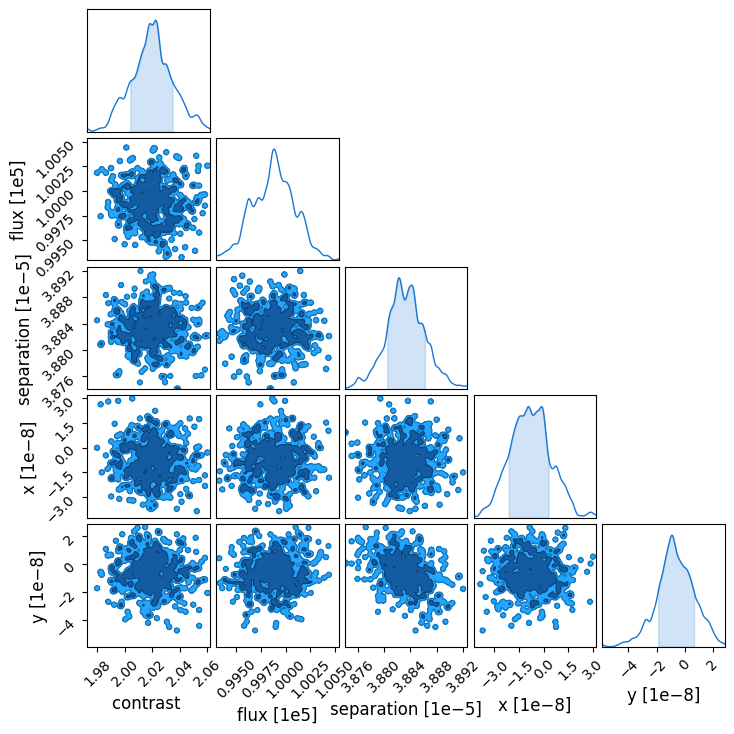

In [19]:
out: object = cc.ChainConsumer().add_chain(samples).plotter.plot()

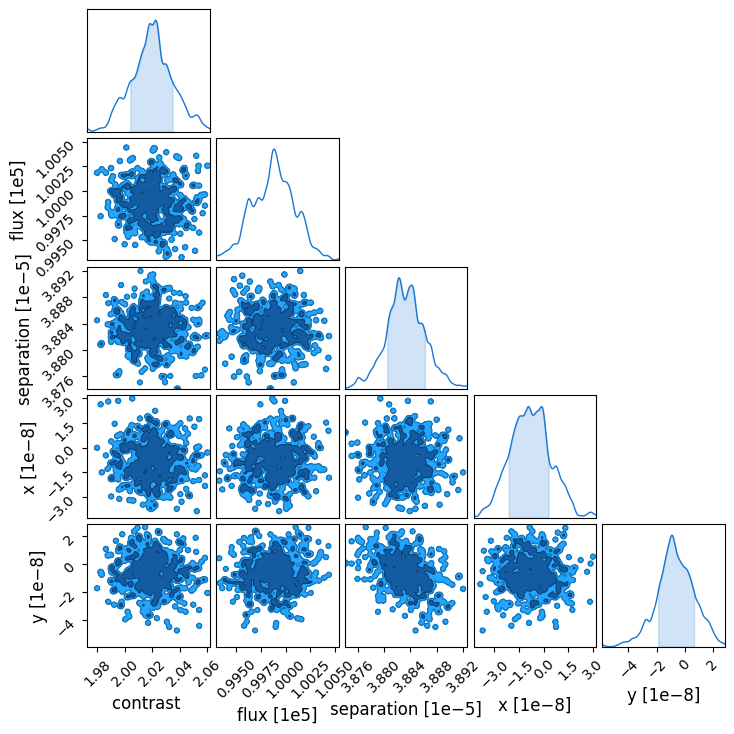